In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import gym

# 建力Policy Gradient模型

In [2]:
class Policy_Gradient:
    
    def __init__(
        self, 
        n_actions, 
        n_states, 
        gamma = 0.9, #遠見程度
        epsilon = None,  #保守程度，越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        epsilon_increase = None,
        learning_rate = 0.001, #神經網路的更新率
        #memory_size = 50, #####
        #batch_size = 32, #####
        nueron_num = 10
    ):
    
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        #self.epsilon_max = epsilon #####
        #self.epsilon_increase = epsilon_increase #####
        #self.epsilon = 0 if epsilon_increase is not None else epsilon #####
        self.lr = learning_rate
        #self.memory_size = memory_size #####
        #self.memory_counter = 0 #####
        #self.batch_size = batch_size ####
        self.nueron_num = nueron_num
        
        ##### initialize memory
        """
        
        """
        self.past_state, self.past_action, self.past_reward = [], [], []
        self.action_one_hot = np.zeros(self.n_actions, dtype=np.int32)

        """

        """
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() #宣告session
        #輸入current state
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'state_input',
                                          dtype = tf.float32)
        """
        輸入real action和神經網路的output act_proba算cross entropy當作更新方向
        以超級瑪莉的遊戲為例 action = [上, 下, 左, 右] 如果實際action為向左則
        action = [0, 0, 1, 0]。
        也可以將這四個動作用0, 1, 2 ,3代表，如此的話只需要用一維來存取動作，也就是輸
        入shape = [None, 1]，那後面再算cross entropy的話就要用tf.nn.sparse_
        softmax_cross_entropy_with_logits，大家也可以試著改寫看看。
        """    
        self.real_action = tf.placeholder(shape = [None, self.n_actions], 
                                          name = 'real_action',
                                          dtype = tf.float32)
        """
        但是有時候產生的動作會帶來好的效果或壞的效果並且程度不一，因此loss不能光用神經網路的
        輸出action_proba和real action的cross entropy代表，因此這邊乘上Vt來校正loss。
        例如某個動作很有幫助那必然會產生很大的action_reward，因此乘上很大的action_reward
        即可加大loss讓此動作之後產生的機率被放大；相反的，某個動作如果產生很好的效果反而會帶
        來負的action_reward使得loss變負的，讓更新方向相反使得之後輸出此動作的機會減少。
        """
        self.Vt = tf.placeholder(shape= [None, ], 
                                            name="Vt",
                                            dtype = tf.float32)
        #搭建神經網路
        with tf.variable_scope('Actor'):
            self.act_proba = self.build_network(self.nueron_num, Trainable = True, \
                             scope = 'net_eval') 
            
        
        #管理神經網路的parameters
        self.Actor_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/net_eval')
        
        
        #loss
        """
        算出 “神經網路輸出的動作機率”與 “實際動作”的cross entropy當作loss，但是更新的方向和力道就利用action
        reward來決定。例如，這一回合產生的所有動作組合如果得到很好的reward，那就應該讓神經網路的輸出機率更靠近實
        際輸出的結果，因此cross_entropy和action_reward相乘的到的loss就更大，更新力度就更大。相反的，這一回
        合產生的所有動作組合如果得到負的reward，那就應該讓神經網路輸出動作的機率更遠離實際輸出結果，在這樣的狀況
        下，cross_entropy和action_reward相乘的到的loss就會得到負的，神經網路的參數更新方向就會往反方向。
        """
        self.cross_entropy = tf.reduce_sum(-tf.log(self.act_proba)*self.real_action, axis=1)
        self.loss = tf.reduce_sum(self.cross_entropy*self.Vt)
 
        
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Actor_eval_params)
    
        self.sess.run(tf.global_variables_initializer()) #將神經網路初始化
    
    def write_memory(self, current_state, reward, action): #####
        
        action_one_hot = self.action_one_hot.copy()
        action_one_hot[action] = 1
        self.past_state.append(current_state)
        self.past_action.append(action_one_hot)
        self.past_reward.append(reward)
    
    
    def build_network(self, neuron_num, Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
            x_h2 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)
            
            output = tf.layers.dense(inputs = x_h2, units = self.n_actions, \
                   activation = tf.nn.softmax, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)#輸出為個行為的機率，因此使用softmax
            
        
        return output #輸出‘不同動作’對應的Q值 
               
 
            
    def choose_action(self, current_state):
        
        act_proba = self.sess.run(self.act_proba, feed_dict={self.state_input: current_state[np.newaxis, :]})
        """
        根據神經網路輸出個動作的機率當作權重做隨機抽樣選出動作。一樣舉超級瑪莉的例子，如果輸出
        [上, 下, 左, 右]的機率分別為[0.3, 0.1, 0.2, 0.4]，那做隨機抽樣就分別有30%, 10%, 
        20%和40%的機率抽到上、下、左、右，因為這樣的做法已具有隨機性因此不需要用epsilon來控制
        行為的隨機程度來增加探索。
        """
        self.action = np.random.choice(range(act_proba.shape[1]), p=act_proba.ravel())  
   
        return self.action
    
    def learn(self): #####
        
        #用reward算出更新向量
        Vt = self.calculate_Vt(self.past_reward)
        #print(np.array(self.past_action).shape)
        #print(np.array(self.past_action))
        #將整個episode的資料放進來做更新
        self.sess.run(self.train, feed_dict={
             self.state_input: np.vstack(self.past_state),  # shape=[None, n_state]
             self.real_action: np.array(self.past_action),  # shape=[None, n_actions]
             self.Vt: np.array(Vt)  # shape=[None, ]
        })
        #更新完後將記憶庫清空
        self.past_state, self.past_action, self.past_reward = [], [], []    
    
    def calculate_Vt(self, reward):
        # discount episode rewards
        Vt = np.zeros_like(reward, dtype=np.float64)
        Vt_temp = 0
        for t in reversed(range(0, len(reward))):
            Vt_temp = reward[t] + Vt_temp * self.gamma
            Vt[t] = Vt_temp

        # normalize episode rewards
        
        Vt -= np.mean(Vt)
        Vt /= np.std(Vt)
        
        return Vt    
        
    def model_save(self, model_name):
        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))

In [3]:
def training(save_model, model_name):
    step_record = []
    reward_record = []
    for episode in range(200):
        # initial environment並給出起始的state
        current_state = env.reset()
        step = 0
        total_reward = 0
        while True:
            # 產生環境視窗
            env.render()

            # 根據現在的狀態選擇動作
            action = RL.choose_action(current_state)

            # 產生動作和環境互動後產生下一個狀態、獎勵值及遊戲是否結束
            next_state, reward, done, _ = env.step(action)
            
            total_reward+= reward
            
            #這句可加可不加，只是怕因為machine變太強會玩很久不死，所以強迫結束遊戲
            if step > 10000:
                done = True
            
            # 將資訊存至記憶體中以便進行experience replay
            RL.write_memory(current_state, reward, action)
            

            # swap state
            current_state = next_state

            # break while loop when end of this episode
            if done:
                RL.learn()
                print('episode:{} steps:{} total reward:{}'.format(episode, step, total_reward))
                step_record.append(step)
                reward_record.append(total_reward)
                break
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return step_record, reward_record

In [4]:
env = gym.make('CartPole-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped
RL = Policy_Gradient(n_actions = 2, 
                   n_states = 4,
                   gamma = 0.99,
                   learning_rate = 0.01,
                 )
step_record, reward_record = training(save_model = True, model_name='PG_CartPole')

episode:0 steps:10 total reward:11.0
episode:1 steps:11 total reward:12.0
episode:2 steps:10 total reward:11.0
episode:3 steps:9 total reward:10.0
episode:4 steps:36 total reward:37.0
episode:5 steps:18 total reward:19.0
episode:6 steps:20 total reward:21.0
episode:7 steps:26 total reward:27.0
episode:8 steps:11 total reward:12.0
episode:9 steps:14 total reward:15.0
episode:10 steps:12 total reward:13.0
episode:11 steps:13 total reward:14.0
episode:12 steps:22 total reward:23.0
episode:13 steps:10 total reward:11.0
episode:14 steps:17 total reward:18.0
episode:15 steps:11 total reward:12.0
episode:16 steps:37 total reward:38.0
episode:17 steps:16 total reward:17.0
episode:18 steps:11 total reward:12.0
episode:19 steps:28 total reward:29.0
episode:20 steps:20 total reward:21.0
episode:21 steps:32 total reward:33.0
episode:22 steps:21 total reward:22.0
episode:23 steps:23 total reward:24.0
episode:24 steps:29 total reward:30.0
episode:25 steps:24 total reward:25.0
episode:26 steps:30 tot

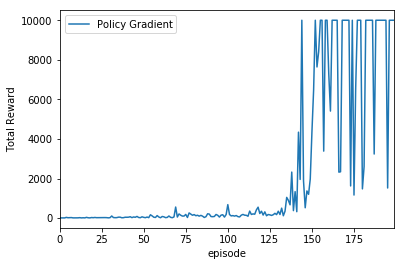

In [8]:
reward_result = pd.DataFrame(reward_record)
reward_result.columns = ['Policy Gradient']
reward_result.plot()
plt.xlabel('episode')
plt.ylabel('Total Reward')
plt.show()